# LangSmith API Key 로드

In [1]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv()

True

# Langsmith로 프로젝트 추적 설정

In [2]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "RAG_NaverNews"

# 네이버 뉴스 기반 QA(Question-Answering) 챗봇

네이버 뉴스기사의 내용에 대해 질문할 수 있는 뉴스기사 QA 앱 을 구축할 것입니다.

웹 페이지의 내용을 로드하고, 텍스트를 청크로 나누어 인덱싱하는 과정을 거친 후, 관련된 텍스트 스니펫을 검색하여 새로운 내용을 생성하는 과정을 구현합니다.

# 모듈 임포트

In [3]:
import bs4 # 웹 페이지를 파싱하기 위한 라이브러리
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter # 텍스트 분할
from langchain_community.document_loaders import WebBaseLoader # 문서 로딩
from langchain_community.vectorstores import Chroma, FAISS # 벡터 저장
from langchain_core.output_parsers import StrOutputParser # 출력 파싱
from langchain_core.runnables import RunnablePassthrough # 실행 가능한 패스스루
from langchain_openai import ChatOpenAI, OpenAIEmbeddings # OpenAI의 챗봇과 임베딩 기능 사용

USER_AGENT environment variable not set, consider setting it to identify your requests.


WebBaseLoader는 지정된 웹 페이지에서 필요한 부분만을 파싱하기 위해 bs4.SoupStrainer를 사용합니다.

bs4.SoupStrainer 는 편리하게 웹에서 원하는 요소를 가져올 수 있도록 해줍니다.

# 문서로더

pdf, csv, webbaseloader, json

In [4]:
# 뉴스기사 내용을 로드하고, 청크로 나누고, 인덱싱합니다.
loader = WebBaseLoader(
    web_paths=("https://n.news.naver.com/article/437/0000378416",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            "div",
            attrs={"class": ["newsct_article _article_body", "media_end_head_title"]},
        )
    ),
)

docs = loader.load()
print(f"문서의 수: {len(docs)}")
docs

문서의 수: 1


[Document(metadata={'source': 'https://n.news.naver.com/article/437/0000378416'}, page_content="\n출산 직원에게 '1억원' 쏜다…회사의 파격적 저출생 정책\n\n\n[앵커]올해 아이 낳을 계획이 있는 가족이라면 솔깃할 소식입니다. 정부가 저출생 대책으로 매달 주는 부모 급여, 0세 아이는 100만원으로 올렸습니다. 여기에 첫만남이용권, 아동수당까지 더하면 아이 돌까지 1년 동안 1520만원을 받습니다. 지자체도 경쟁하듯 지원에 나섰습니다. 인천시는 새로 태어난 아기, 18살될 때까지 1억원을 주겠다. 광주시도 17살될 때까지 7400만원 주겠다고 했습니다. 선거 때면 나타나서 아이 낳으면 현금 주겠다고 밝힌 사람이 있었죠. 과거에는 표만 노린 '황당 공약'이라는 비판이 따라다녔습니다. 그런데 지금은 출산율이 이보다 더 나쁠 수 없다보니, 이런 현금성 지원을 진지하게 정책화 하는 상황까지 온 겁니다. 게다가 기업들도 뛰어들고 있습니다. 이번에는 출산한 직원에게 단번에 1억원을 주겠다는 회사까지 나타났습니다.이상화 기자가 취재했습니다.[기자]한 그룹사가 오늘 파격적인 저출생 정책을 내놨습니다.2021년 이후 태어난 직원 자녀에 1억원씩, 총 70억원을 지원하고 앞으로도 이 정책을 이어가기로 했습니다.해당 기간에 연년생과 쌍둥이 자녀가 있으면 총 2억원을 받게 됩니다.[오현석/부영그룹 직원 : 아이 키우는 데 금전적으로 많이 힘든 세상이잖아요. 교육이나 생활하는 데 큰 도움이 될 거라 생각합니다.]만약 셋째까지 낳는 경우엔 국민주택을 제공하겠다는 뜻도 밝혔습니다.[이중근/부영그룹 회장 : 3년 이내에 세 아이를 갖는 분이 나올 것이고 따라서 주택을 제공할 수 있는 계기가 될 것으로 생각하고.][조용현/부영그룹 직원 : 와이프가 셋째도 갖고 싶어 했는데 경제적 부담 때문에 부정적이었거든요. (이제) 긍정적으로 생각할 수 있을 것 같습니다.]오늘 행사에서는, 회사가 제공하는 출산장려금은 받는 

[Document(metadata={'source': 'https://n.news.naver.com/article/437/0000378416'}, page_content="\n출산 직원에게 '1억원' 쏜다…회사의 파격적 저출생 정책\n\n\n[앵커]올해 아이 낳을 계획이 있는 가족이라면 솔깃할 소식입니다. 정부가 저출생 대책으로 매달 주는 부모 급여, 0세 아이는 100만원으로 올렸습니다. 여기에 첫만남이용권, 아동수당까지 더하면 아이 돌까지 1년 동안 1520만원을 받습니다. 지자체도 경쟁하듯 지원에 나섰습니다. 인천시는 새로 태어난 아기, 18살될 때까지 1억원을 주겠다. 광주시도 17살될 때까지 7400만원 주겠다고 했습니다. 선거 때면 나타나서 아이 낳으면 현금 주겠다고 밝힌 사람이 있었죠. 과거에는 표만 노린 '황당 공약'이라는 비판이 따라다녔습니다. 그런데 지금은 출산율이 이보다 더 나쁠 수 없다보니, 이런 현금성 지원을 진지하게 정책화 하는 상황까지 온 겁니다. 게다가 기업들도 뛰어들고 있습니다. 이번에는 출산한 직원에게 단번에 1억원을 주겠다는 회사까지 나타났습니다.이상화 기자가 취재했습니다.[기자]한 그룹사가 오늘 파격적인 저출생 정책을 내놨습니다.2021년 이후 태어난 직원 자녀에 1억원씩, 총 70억원을 지원하고 앞으로도 이 정책을 이어가기로 했습니다.해당 기간에 연년생과 쌍둥이 자녀가 있으면 총 2억원을 받게 됩니다.[오현석/부영그룹 직원 : 아이 키우는 데 금전적으로 많이 힘든 세상이잖아요. 교육이나 생활하는 데 큰 도움이 될 거라 생각합니다.]만약 셋째까지 낳는 경우엔 국민주택을 제공하겠다는 뜻도 밝혔습니다.[이중근/부영그룹 회장 : 3년 이내에 세 아이를 갖는 분이 나올 것이고 따라서 주택을 제공할 수 있는 계기가 될 것으로 생각하고.][조용현/부영그룹 직원 : 와이프가 셋째도 갖고 싶어 했는데 경제적 부담 때문에 부정적이었거든요. (이제) 긍정적으로 생각할 수 있을 것 같습니다.]오늘 행사에서는, 회사가 제공하는 출산장려금은 받는 직원들의 세금 부담을 고려해 정부가 면세해달라는 제안도 나왔습니다.이같은 출산장려책은 점점 확산하는 분위기입니다.법정기간보다 육아휴직을 길게 주거나, 남성 직원의 육아휴직을 의무화한 곳도 있습니다.사내 어린이집을 밤 10시까지 운영하고 셋째를 낳으면 무조건 승진시켜 주기도 합니다.한 회사는 지난해 네쌍둥이를 낳은 직원에 의료비를 지원해 관심을 모았습니다.정부 대신 회사가 나서는 출산장려책이 사회적 분위기를 바꿀 거라는 기대가 커지는 가운데, 여력이 부족한 중소지원이 필요하다는 목소리도 나옵니다.[영상디자인 곽세미]\n\t\t\n")]

# 텍스트 분할

1. 재귀적 문자 텍스트 분할

    이 텍스트 분할기는 일반적인 텍스트에 권장되는 방식입니다.

    이 분할기는 문자 목록을 매개변수로 받아 동작합니다.

    분할기는 청크가 충분히 작아질 때까지 주어진 문자 목록의 순서대로 텍스트를 분할하려고 시도합니다.

    기본 문자 목록은 ["\n\n", "\n", " ", ""]입니다.

    단락 -> 문장 -> 단어 순서로 재귀적으로 분할합니다.

    이는 단락(그 다음으로 문장, 단어) 단위가 의미적으로 가장 강하게 연관된 텍스트 조각으로 간주되므로, 가능한 한 함께 유지하려는 효과가 있습니다.



2. 토큰 텍스트 분할

In [5]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

splits = text_splitter.split_documents(docs)
len(splits)

3

# 임베딩

OpenAIEmbeddings, 캐시 임베딩

# 벡터 저장소

FAISS 혹은 Chroma와 같은 vectorstore는 이러한 청크를 바탕으로 문서의 벡터 표현을 생성합니다.

In [7]:
# 벡터스토어를 생성합니다.
vectorstore = FAISS.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# 뉴스에 포함되어 있는 정보를 검색하고 생성합니다.
retriever = vectorstore.as_retriever()

vectorstore.as_retriever()를 통해 생성된 검색기는 hub.pull로 가져온 프롬프트와 ChatOpenAI 모델을 사용하여 새로운 내용을 생성합니다.

# 검색기

벡터 저장소 기반 검색기

In [8]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(
    """당신은 질문-답변(Question-Answering)을 수행하는 친절한 AI 어시스턴트입니다. 
    당신의 임무는 주어진 문맥(context) 에서 주어진 질문(question) 에 답하는 것입니다.
    검색된 다음 문맥(context) 을 사용하여 질문(question) 에 답하세요. 
    만약, 주어진 문맥(context) 에서 답을 찾을 수 없다면, 
    답을 모른다면 `주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다` 라고 답하세요.
    한글로 답변해 주세요. 단, 기술적인 용어나 이름은 번역하지 않고 그대로 사용해 주세요.

    #Question: 
    {question} 

    #Context: 
    {context} 

    #Answer:
"""
)


hub 에서 selena/rag-prompt-korean 프롬프트를 다운로드 받아 입력할 수 있습니다. 이런 경우 별도의 프롬프트 작성과정이 생략됩니다.

In [ ]:
# prompt = hub.pull("selena/rag-prompt-korean")
# prompt

In [21]:
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)


# 체인을 생성합니다.
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

스트리밍 출력을 위하여 stream_response 를 사용합니다.

In [12]:
from utils.messages import stream_response

In [13]:
answer = rag_chain.stream("부영그룹의 출산 장려 정책에 대해 설명해주세요.")
stream_response(answer)

부영그룹의 출산 장려 정책은 출산한 직원에게 금전적인 지원을 제공하는 것입니다. 2021년 이후 태어난 직원 자녀에게 1억원씩, 총 70억원을 지원하며, 연년생과 쌍둥이 자녀가 있는 경우 총 2억원을 받을 수 있습니다. 또한, 셋째 아이를 낳는 경우 국민주택을 제공하겠다는 계획도 있습니다. 이러한 정책은 직원들이 아이를 키우는 데 있어 경제적 부담을 덜어주고자 하는 목적으로 시행되고 있습니다.

부영그룹의 출산 장려 정책은 출산한 직원에게 금전적인 지원을 제공하는 것입니다. 2021년 이후 태어난 직원 자녀에게 1억원씩, 총 70억원을 지원하며, 연년생과 쌍둥이 자녀가 있는 경우 총 2억원을 받을 수 있습니다. 또한, 셋째 아이를 낳는 경우 국민주택을 제공하겠다는 계획도 있습니다. 이러한 정책은 직원들이 아이를 키우는 데 있어 경제적 부담을 덜어주고자 하는 목적으로 시행되고 있습니다.

LangSmith 에서 결과를 호출한 내용에 대해 추적해볼 수 있습니다. 

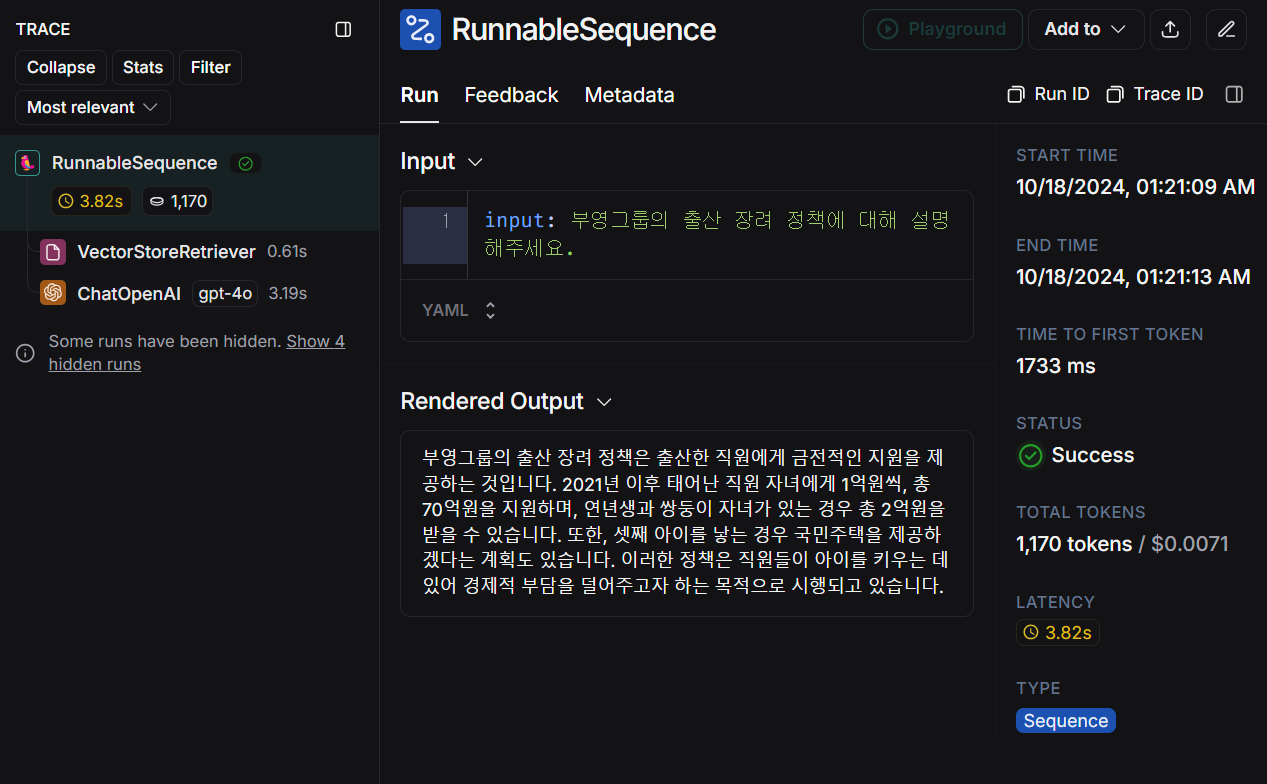

In [15]:
answer = rag_chain.stream("부영그룹은 출산 직원에게 얼마의 지원을 제공하나요?")
stream_response(answer)

부영그룹은 출산한 직원에게 1억원을 지원합니다. 또한, 연년생과 쌍둥이 자녀가 있는 경우 총 2억원을 받을 수 있으며, 셋째 아이를 낳는 경우 국민주택을 제공하겠다는 정책도 있습니다.

In [23]:
answer = rag_chain.stream("정부의 저출생 대책으로 내세운 것은 무엇인가요?")
stream_response(answer)

정부의 저출생 대책으로 내세운 것은 매달 주는 부모 급여를 0세 아이에게 100만원으로 올리는 것입니다. 또한, 첫만남이용권과 아동수당을 포함하여 아이가 돌까지 1년 동안 총 1520만원을 지원합니다. 추가로, 인천시는 새로 태어난 아기에게 18살이 될 때까지 1억원을 주겠다고 하고, 광주시는 17살이 될 때까지 7400만원을 주겠다고 하는 등 지자체도 지원에 나서고 있습니다.

In [17]:
answer = rag_chain.stream("부영그룹의 임직원 숫자는 몇명인가요?")
stream_response(answer)

주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다.